# Sampling Demo with Cairn.jl

In this notebook, we'll walk through how to perform molecular dynamics (MD) simulation with the 2D potentials using the package Cairn.jl. This notebook is designed to run with Julia 1.8.3.

First, load all necessary packages and plotting scripts:

In [29]:
import Pkg
Pkg.activate("/Users/joannazou/Documents/Github/cesmix-mit/Cairn")
Pkg.resolve()

  Activating project at `~/Documents/Github/cesmix-mit/Cairn`
  No Changes to `~/Documents/Github/cesmix-mit/Cairn/Project.toml`
  No Changes to `~/Documents/Github/cesmix-mit/Cairn/Manifest.toml`


In [32]:
using Cairn
using LinearAlgebra, Random, Statistics, StatsBase, Distributions
using PotentialLearning
using Molly
using AtomisticQoIs
using SpecialPolynomials, SpecialFunctions


In [38]:
# plotting scripts - these are kept separate from the package for now
include("/Users/joannazou/Documents/Github/cesmix-mit/Cairn/src/makie/makie.jl")


plot_trigger_hist (generic function with 1 method)

## Example 1: Double well potential

Now we call on `DoubleWell` as our reference potential:

In [34]:
ref = DoubleWell()

DoubleWell{Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(kJ nm⁻¹ mol⁻¹, kJ mol⁻¹)

### Part I: Sampling via overdamped Langevin dynamics

To illustrate the challenges of sampling the Muller Brown potential, we can first look at the molecular dynamics trajectory of a single-particle system using overdamped Langevin dynamics.

For the coordinate position of an atom $\mathbf{x}_t \in \mathbb{R}^2$, the continuous-time overdamped Langevin equation is: 

$$d\mathbf{x}_t = -\nabla_{\mathbf{x}} V(\mathbf{x}_t) \ dt + \sqrt{2} \ dW_t$$

and discrete-time update equation is: 

$$ \mathbf{x}_{t+1} = - \epsilon \nabla_{\mathbf{x}} V(\mathbf{x}_t) + \sqrt{2 \epsilon}  \ \mathbf{w}_t $$

where $V: \mathbb{R}^2 \rightarrow \mathbb{R}$ is the interatomic potential energy, $\nabla_{\mathbf{x}}(\cdot)$ denotes the gradient with respect to coordinate axes of $\mathbf{x}_t$, $\mathbf{w}_t \sim N(0,I)$ is the realization of white noise, and $\epsilon$ is the time step. 

In [35]:
# define properties
atom_mass = 1.0u"g/mol"
boundary = RectangularBoundary(Inf*u"nm")
temp = 10.0u"K"

# define initial system
atoms = [Atom(mass=atom_mass, σ=1.0u"nm", ϵ=1.0u"kJ * mol^-1")]
coords = [SVector(-0.8, 1.2)u"nm"] # initial position
sys = System(
    atoms=atoms,
    coords=coords,
    boundary=boundary,
    general_inters=(ref,),
    loggers=(coords=CoordinateLogger(100; dims=2),),
)

# define simulator
sim_langevin = OverdampedLangevin(
            dt=0.002u"ps",
            temperature=temp,
            friction=1.0u"ps^-1")

OverdampedLangevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}}(0.002 ps, 10.0 K, 1.0 ps⁻¹, 1)

In [36]:
# run simulation - this will take a few seconds
simulate!(sys, sim_langevin, 1_000_000)

System with 1 atoms, boundary RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[Inf nm, Inf nm])

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/joannazou/.julia/packages/Makie/ND0gA/src/scenes.jl:220


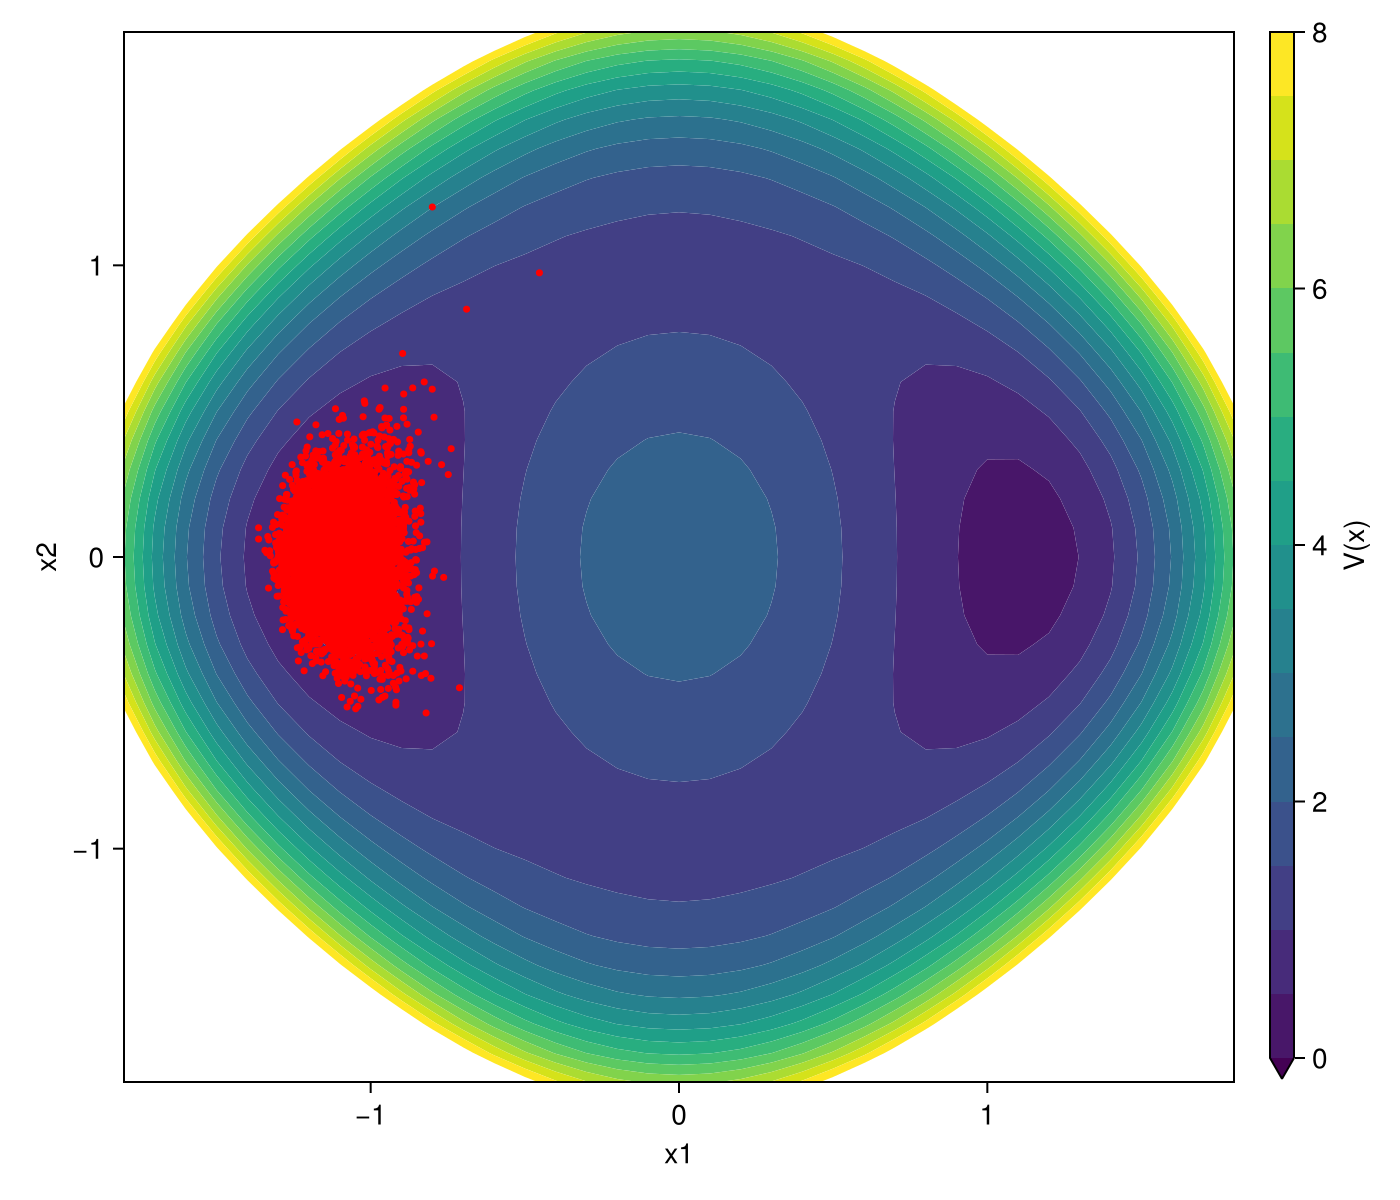

In [39]:
# plot MD trajectory 
dist_units = u"nm"
limits = [[-1.8, 1.8], [-1.8, 1.8]] # boundaries of main support
xcoord = Vector(limits[1][1]:0.1:limits[1][2]) .* dist_units
ycoord = Vector(limits[2][1]:0.1:limits[2][2]) .* dist_units 
ctr_grid = [xcoord, ycoord]
ctr_lvls = 0.0:0.5:8.0

f0 = plot_md_trajectory(sys, ctr_grid, fill=true, lvls=ctr_lvls)

Sampling the double well potential using the `OverdampedLangevin` simulator exhibits metastability, where the stochastic process remains confined to high-probability regions even over long simulation time scales. 

### Part II: Sampling via stochastic SVGD

Next, we show the performance of the `StochasticSVGD` simulator in sampling from the double well potential energy surface.

*Stein variational gradient descent* (SVGD) is a particle-based variational inference algorithm which advances an interacting particle system $\mathbf{X}_t = \{ \mathbf{x}_t^{(i)} \}^J_{i=1}$ by maximally decreasing the gradient of Kullback-Leibler divergence between the empirical distribution of the particles, $\hat{\mu}_t$, and the target distribution $p$ (being the Boltzsmann-Gibbs distribution $p(\mathbf{x}) \propto \exp(-V(\mathbf{x})) \ $). 

The stochastic version of SVGD includes white noise perturbations to each of the particles' trajectories. The continuous-time SDE for particles $i = 1,...,J$ is: 

$$ d\mathbf{x}^{(i)}_t = \phi_t(\mathbf{x}^{(i)}_t, \hat{\mu}_t) dt + \sqrt{2} \ dW^{(i)}_t $$

where the *kernel Stein discrepancy* (KSD) is given by: 

$$ \phi_t(\cdot, \hat{\mu}_t) = \mathbb{E}_{\mathbf{x} \sim \hat{\mu}_t} [-k(\cdot, \mathbf{x}) \nabla_{\mathbf{x}} V(\mathbf{x}) + \nabla_{\mathbf{x}}k(\cdot, \mathbf{x})] $$

Note that we have $\phi_t \rightarrow 0$ as $\hat{\mu}_t \rightarrow p$ in distribution. In essence, one can think of the kernel term $-k(\cdot, \mathbf{x}) \nabla_{\mathbf{x}} V(\mathbf{x})$ as an attractive term, which weights the drift from each particle in the ensemble according to some measure of spatial correlation given by the kernel function, and the gradient kernel term $\nabla_{\mathbf{x}}k(\cdot, \mathbf{x})$ as a repulsive term, which repels particles in the ensemble away from each other. In the deterministic setting (without noise), in the asymptotic time limit with a finite ensemble size, the location of particles converge on "quadrature points" of the target distribution. 


For a finite ensemble, the Monte Carlo estimate $\hat{\phi}_t$ can be computed as:

$$ \hat{\phi}_t(\cdot, \mathbf{X}_t) = \sum_{j=1}^J \big[ -k(\cdot, \mathbf{x}_t^{(j)}) \nabla_{\mathbf{x}^{(j)}} V(\mathbf{x}_t^{(j)}) + \nabla_{\mathbf{x}^{(j)}}k(\cdot, \mathbf{x}_t^{(j)}) \big] $$

The discrete-time update equation in stochastic SVGD is then: 

$$ \mathbf{x}^{(i)}_{t+1} = \epsilon \hat{\phi}_t(\mathbf{x}^{(i)}_t, \mathbf{X}_t) + \sqrt{2 \epsilon}  \ \mathbf{w}_t $$



In order to implement stochastic SVGD, we must first choose a kernel function $k$ which defines the RKHS for Stein variational gradient descent (SVGD). Here we use an RBF (squared exponential) kernel of the form:

$$ k(\mathbf{x},\tilde{\mathbf{x}}) = \beta \exp \Big( -\frac{d(\mathbf{x},\tilde{\mathbf{x}})^2}{2 \ell^2} \Big) $$

where $d$ is chosen to be the Mahalanobis distance with covariance matrix $S$:

$$ d(\mathbf{x},\tilde{\mathbf{x}}) = \sqrt{(\mathbf{x} - \tilde{\mathbf{x}})^T S^{-1} (\mathbf{x} - \tilde{\mathbf{x}})} $$

It suffices to set the covariance matrix $S = \mathbb{I}$, the kernel magnitude $\beta=1$ (such that $k(x,x') = 1$ when $x = x'$), and the kernel bandwidth $\ell = 0.1$ (determined by the scale of the potential function).

In [40]:
# define kernel
rbf = RBF(Euclidean(2), β=0.2, ℓ = 0.1) 

RBF(Euclidean{Float64}([1.0 0.0; 0.0 1.0], [1.0 0.0; 0.0 1.0]), 1.0e-8, 0.1, 0.2)

Next, we initialize the ensemble at time $t=0$ as a random sample of $n$ points from the MD trajectory we ran previously using `OverdampedLangevin`.


In [41]:
# define initial ensemble
nens = 10
id = StatsBase.sample(1:length(sys.loggers.coords.history), nens, replace=false)
coords_train = [sys.loggers.coords.history[i][1] for i in id] 
atoms_train = [Atom(mass=atom_mass, σ=1.0u"nm", ϵ=1.0u"kJ * mol^-1") for i in 1:nens]

ens0 = [System(
    atoms=[atoms_i],
    coords=[coords_i],
    boundary=boundary,
    general_inters=(ref,),
    # k = 1.0u"kJ * K^-1 * mol^-1",
    loggers=(
        coords=CoordinateLogger(10; dims=2),
        ksd=StepComponentLogger(10; dims=2),
    )
) for (atoms_i, coords_i) in zip(atoms_train, coords_train)]

10-element Vector{System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{DoubleWell{Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, Tuple{}, NoNeighborFinder, @NamedTuple{coords::GeneralObservableLogger{Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, typeof(Molly.coordinates_wrapper)}, ksd::StepComponentLogger{Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(g⁻¹, kJ, nm⁻¹,

#### Case A: Deterministic Ensemble Dynamics

Now, define the `StochasticSVGD` simulator, using the RBF kernel with the median bandwidth heuristic and the initial ensemble defining the fixed system. Here we first consider deterministic dynamics, meaning no noise is added to the system; this is represented by setting the temperature to $0.0 K$. 

In [42]:
# define fixed system
sys_fix = remove_loggers(ens0)

# define simulator
sim_svgd = StochasticSVGD(
            dt=0.002u"ps",
            kernel=rbf,
            kernel_bandwidth=median_kernel_bandwidth,
            sys_fix=sys_fix,
            temperature=0.0u"K",
            friction=1.0u"ps^-1")

StochasticSVGD{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, RBF, System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{DoubleWell{Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, Tuple{}, NoNeighborFinder, Tuple{}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝚯⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, K⁻¹, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝚯⁻¹ 𝐓⁻², nothing}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mo

In [43]:
# run simulation - this will take a few seconds
ens = deepcopy(ens0)
simulate!(ens, sim_svgd, 20_000)

20000-element Vector{Float64}:
 0.09186114139648417
 0.09212973716137629
 0.09233501023457114
 0.0929320000582134
 0.09293542513991199
 0.0930799112700158
 0.09343786571819579
 0.09350709134590084
 0.09366567188032046
 0.09391817775654769
 ⋮
 1.1658258627108062
 1.165839822673437
 1.1658537812481202
 1.1658677384348823
 1.1658816942337495
 1.1658956486447483
 1.1659096016679056
 1.1659235533032486
 1.1659375035508044

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/joannazou/.julia/packages/Makie/ND0gA/src/scenes.jl:220


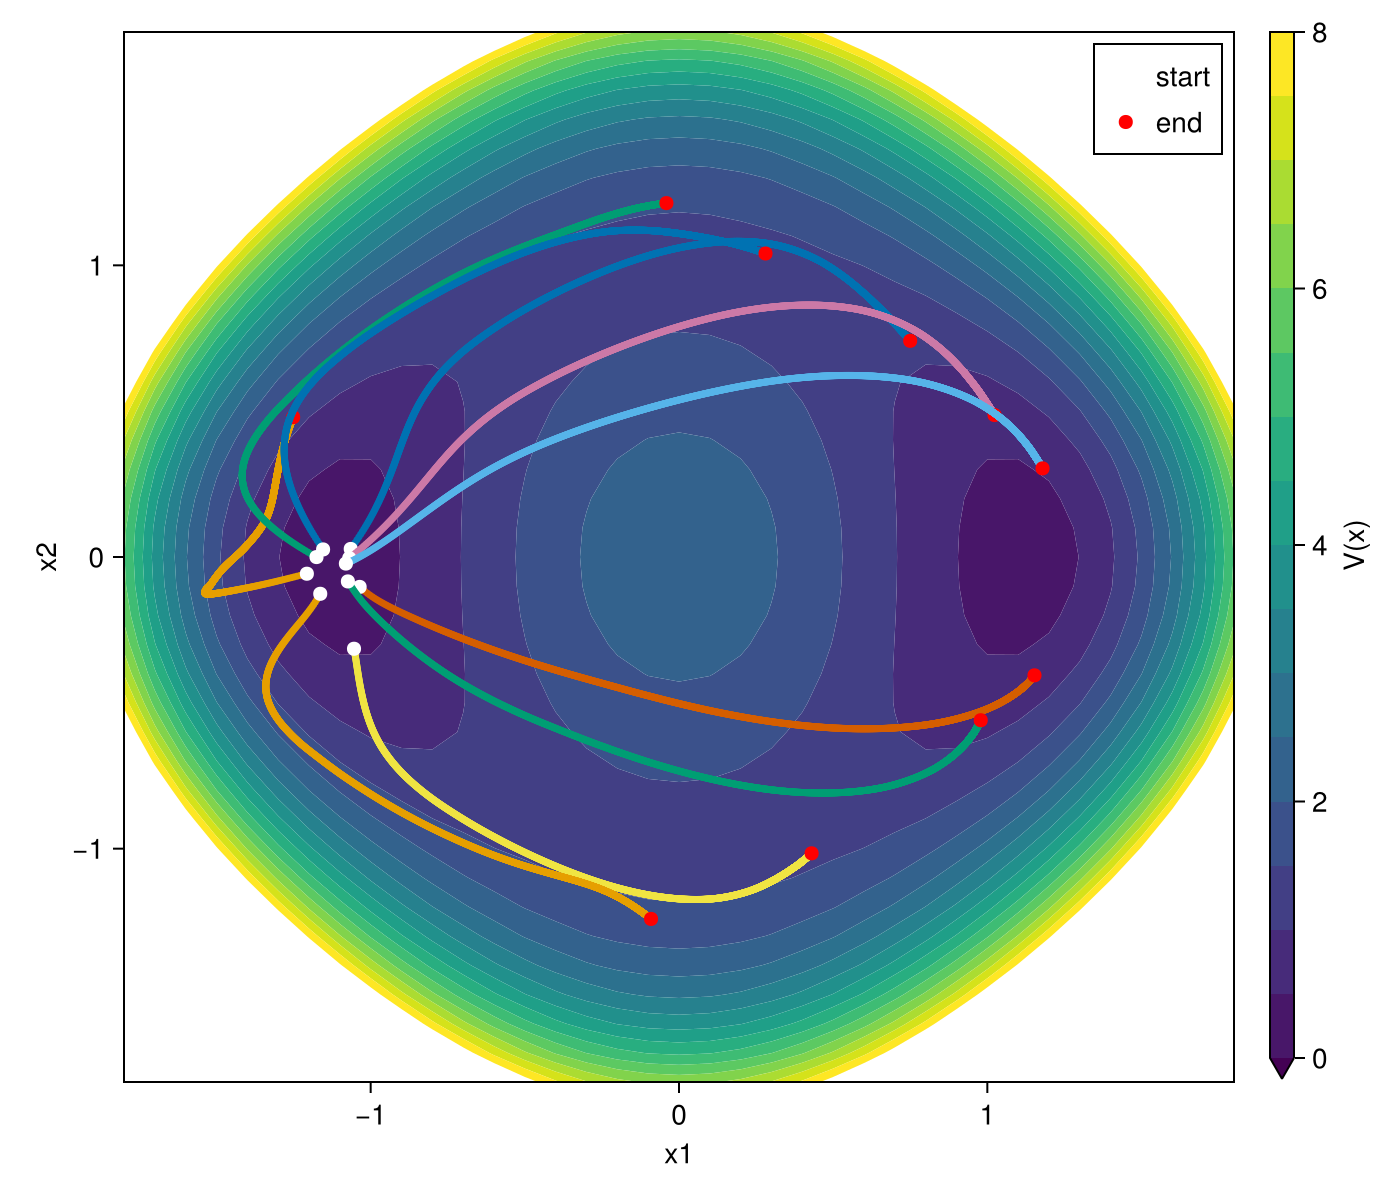

In [44]:
f1 = plot_md_trajectory(ens, ctr_grid, fill=true, lvls=ctr_lvls, showpath=false)

We can use the Stein variational update as a heuristic for convergence of the deterministic dynamics. In particular, we expect $\phi_t(\cdot, \hat{\mu}_t) \to 0$ in the limit of large $t$.

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/joannazou/.julia/packages/Makie/ND0gA/src/scenes.jl:220


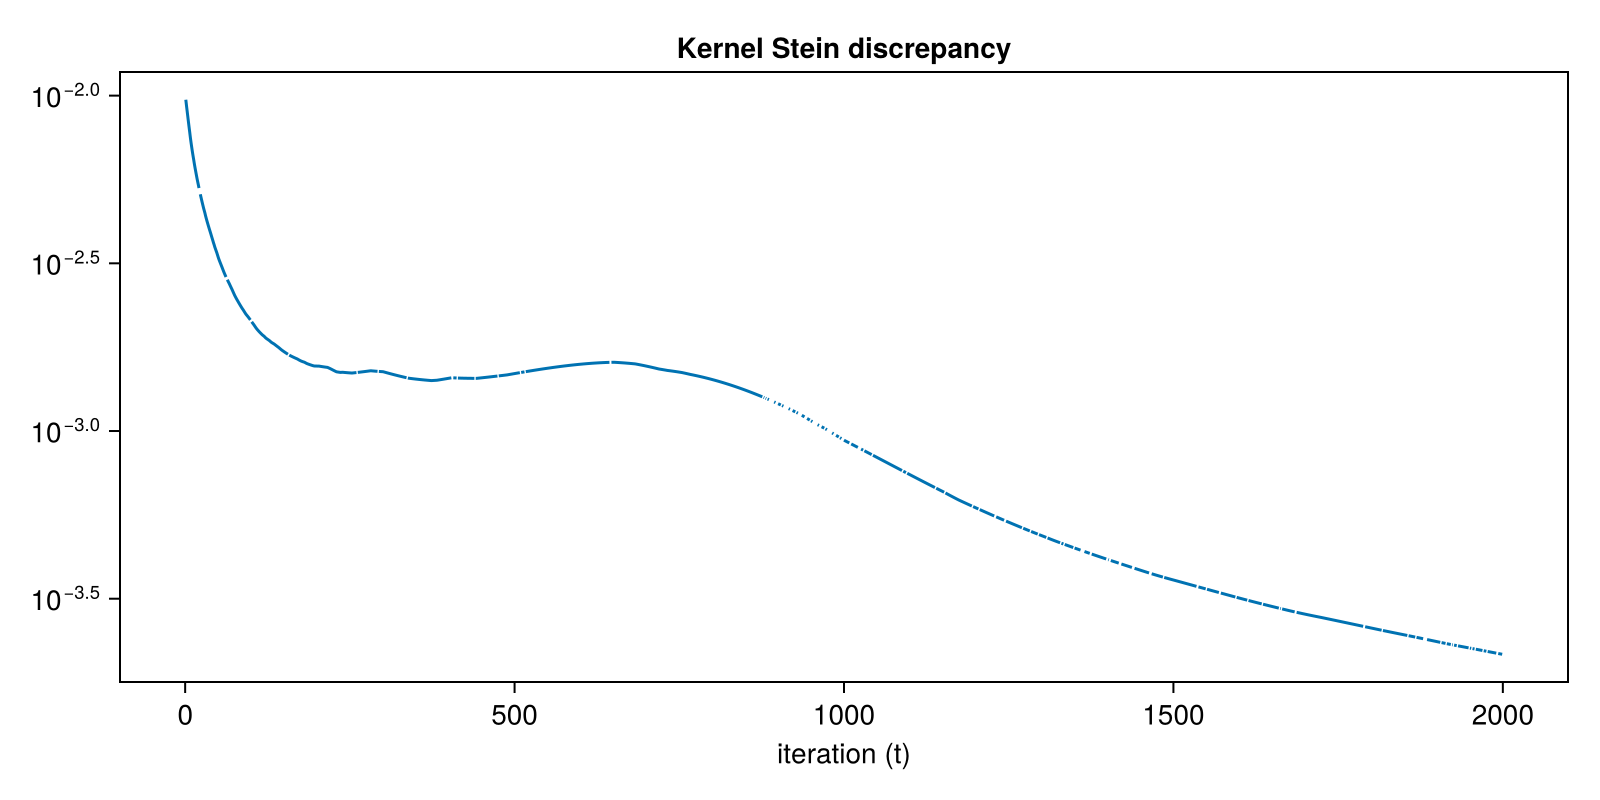

In [45]:
f1b = plot_step_mean(ens, "Kernel Stein discrepancy", logscl=true)

One should observe that the final positions of the ensemble has greater spread over the potential energy surface compared to the trajectory from `OverdampedLangevin`.

When we increase the ensemble size to $n = 100$, we see the same dispersive behavior of the ensemble dynamics. However, since the cost of ensemble simulation scales $\mathcal{O}(n^2)$, due to the calculation of pairwise kernel terms, it is not practical to run `StochasticSVGD` with larger ensemble sizes.

![image](./figures/stochsvgd_100.png)

#### Case B: Stochastic Ensemble Dynamics

Rather than increase the ensemble size to generate more diverse sets of particles, we consider introducing diversity in the dynamics through the addition of noise, or "temperature" to the system. 

In [46]:
# define simulator
sim_svgd = StochasticSVGD(
            dt=0.002u"ps",
            kernel=rbf,
            kernel_bandwidth=median_kernel_bandwidth,
            sys_fix=sys_fix,
            temperature=1.0u"K",
            friction=1.0u"ps^-1")

StochasticSVGD{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, RBF, System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{DoubleWell{Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, Tuple{}, NoNeighborFinder, Tuple{}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝚯⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, K⁻¹, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝚯⁻¹ 𝐓⁻², nothing}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mo

In [47]:
ens = deepcopy(ens0)
simulate!(ens, sim_svgd, 20_000)

20000-element Vector{Float64}:
 0.09186114139648417
 0.08968459567677954
 0.0914296991966671
 0.0912455543556838
 0.09124583097286197
 0.09127074206470587
 0.09275674666716016
 0.09293542513991199
 0.0937337802181334
 0.0930410230324717
 ⋮
 1.1228662279048403
 1.117166699810623
 1.114281653250607
 1.1112802618771573
 1.1137799748168469
 1.1167549781283455
 1.1143492428747168
 1.1119584914542349
 1.11469124496476

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/joannazou/.julia/packages/Makie/ND0gA/src/scenes.jl:220


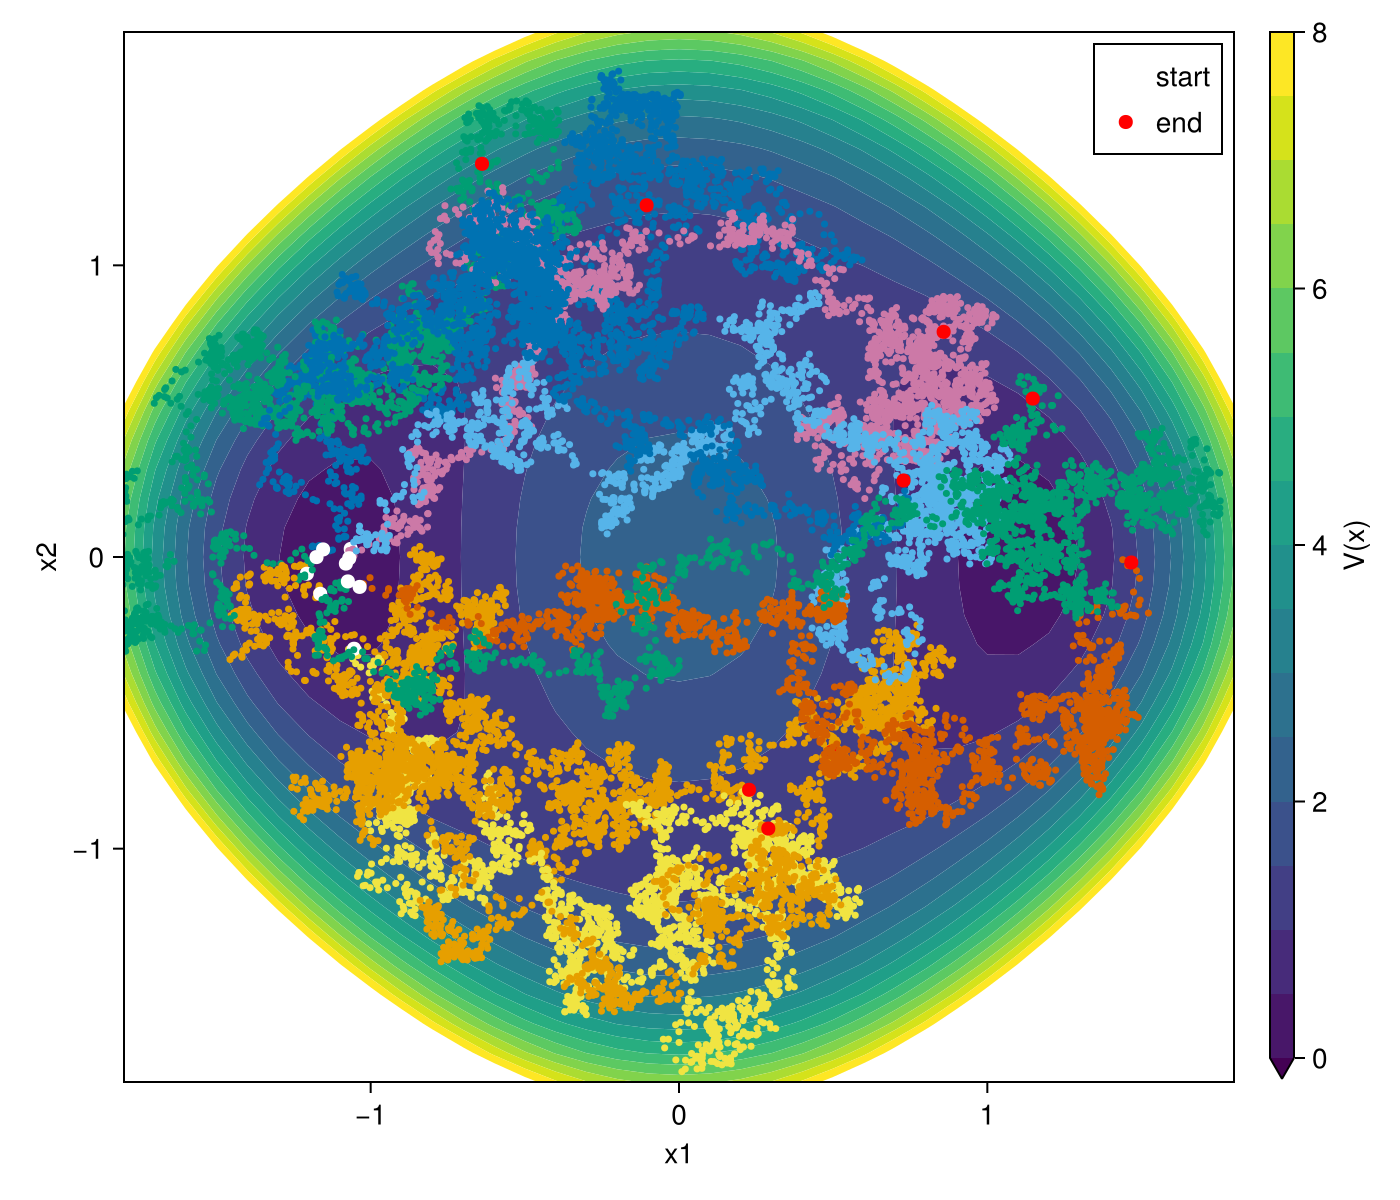

In [48]:
f2 = plot_md_trajectory(ens, ctr_grid, fill=true, lvls=ctr_lvls, showpath=false)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/joannazou/.julia/packages/Makie/ND0gA/src/scenes.jl:220


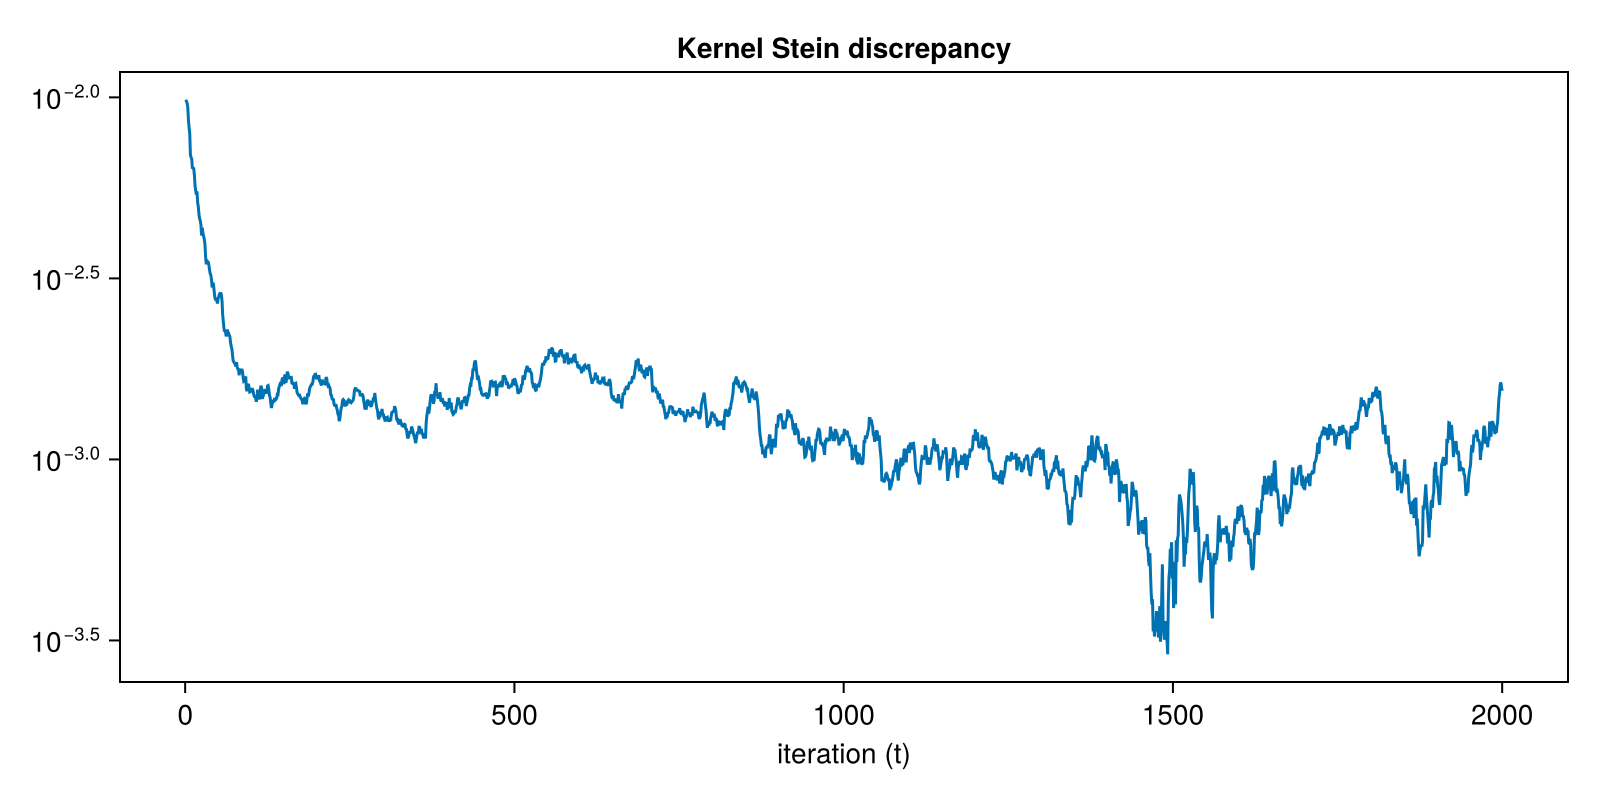

In [49]:
f1b = plot_step_mean(ens, "Kernel Stein discrepancy", logscl=true)


Note that in the stochastic setting, while we achieve more diverse coverage of the potential energy landscape, the Stein update function $\phi_t$ is a less useful diagnostic for convergence, since it fluctuates from the effect of noisy dynamics. 

## Example 2: Muller-Brown potential

We can apply the same routine to the Muller Brown potential, where we will see that the addition of noise plays a crucial role in overcoming mode collapse of the standard SVGD algorithm.

Now, define our reference potential to be ``MullerBrown`` (native to Molly):

In [50]:
ref = MullerBrown()

MullerBrown{SVector{4, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}(Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}[-200.0 kJ mol⁻¹, -100.0 kJ mol⁻¹, -170.0 kJ mol⁻¹, 15.0 kJ mol⁻¹], Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}[-1.0 nm⁻², -1.0 nm⁻², -6.5 nm⁻², 0.7 nm⁻²], Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}[0.0 nm⁻², 0.0 nm⁻², 11.0 nm⁻², 0.6 nm⁻²], Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}[-10.0 nm⁻², -10.0 nm⁻², -6.5 nm⁻², 0.7 nm⁻²], Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[1.0 nm, 0.0 nm, -0.5 nm, -1.0 nm], Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋,

Sample the potential energy surface with vanilla Langevin dynamics:

In [51]:
# define properties
atom_mass = 1.0u"g/mol"
boundary = RectangularBoundary(Inf*u"nm")
temp = 100.0u"K"

# define initial system
atoms = [Atom(mass=atom_mass, σ=0.3u"nm", ϵ=0.2u"kJ * mol^-1")]
coords = [SVector(-0.8, 1.2)u"nm"] # initial position
sys = System(
    atoms=atoms,
    coords=coords,
    boundary=boundary,
    general_inters=(ref,),
    loggers=(coords=CoordinateLogger(100; dims=2),),
)

# define simulator
sim_langevin = OverdampedLangevin(
            dt=0.002u"ps",
            temperature=temp,
            friction=4.0u"ps^-1")

OverdampedLangevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}}(0.002 ps, 100.0 K, 4.0 ps⁻¹, 1)

In [52]:
# run simulation - this will take a few seconds
simulate!(sys, sim_langevin, 5_000_000)

System with 1 atoms, boundary RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[Inf nm, Inf nm])

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/joannazou/.julia/packages/Makie/ND0gA/src/scenes.jl:220


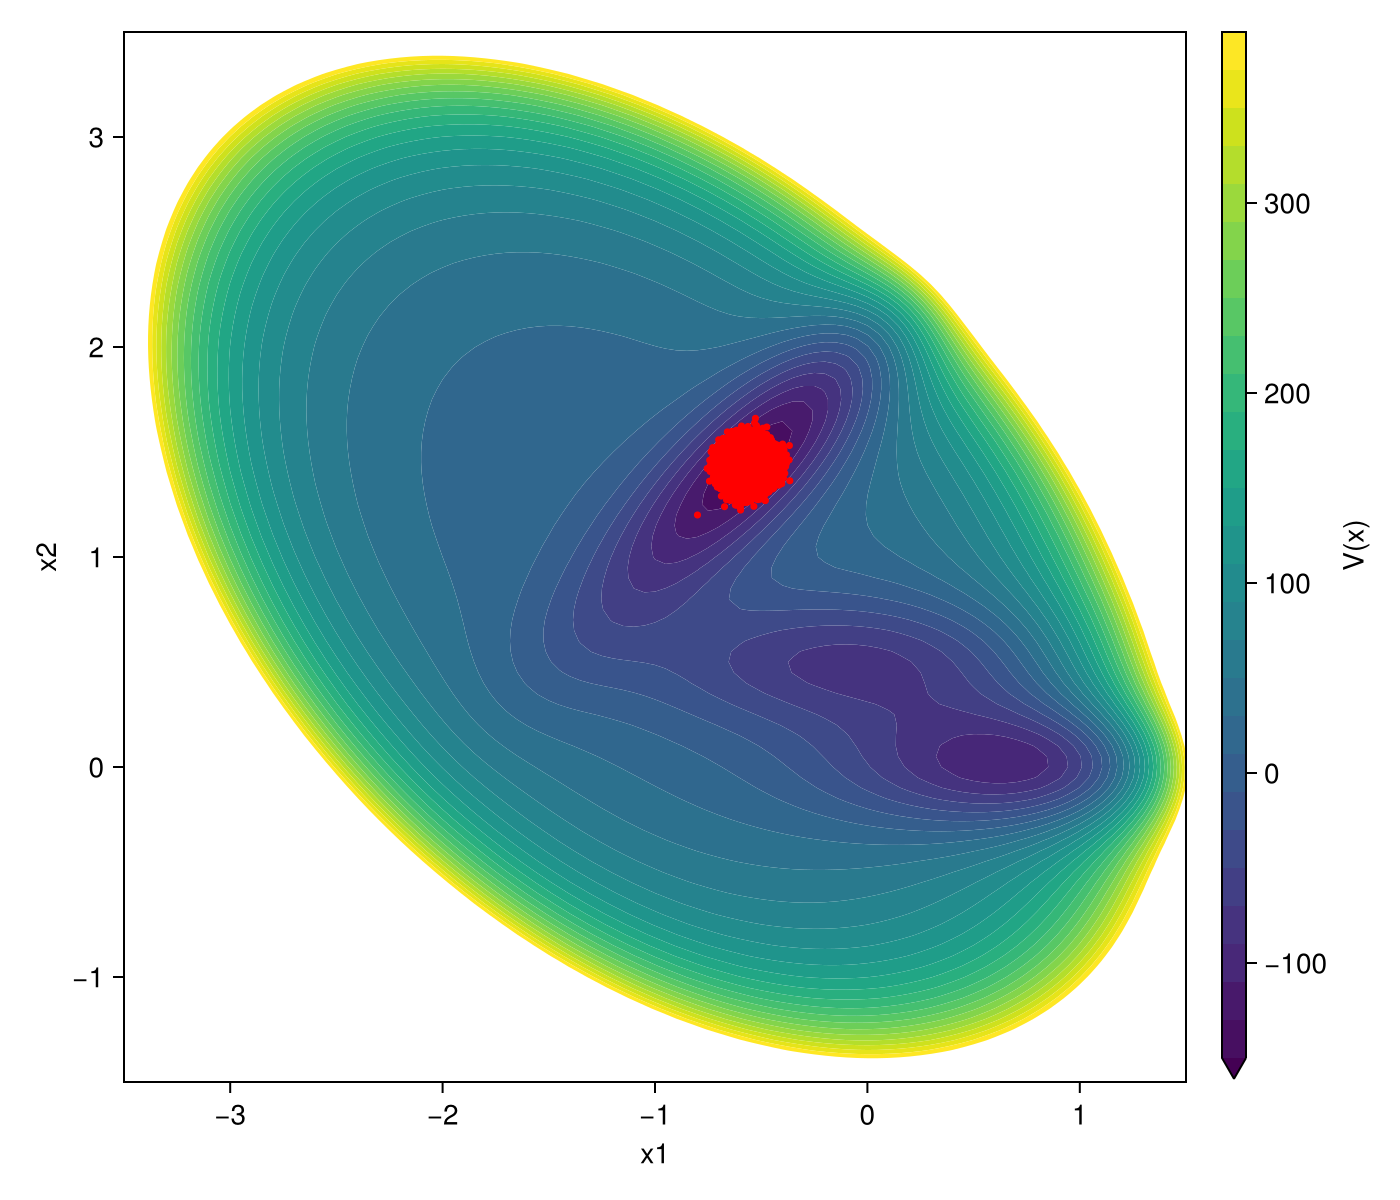

In [53]:
# plot MD trajectory 
dist_units = u"nm"
xcoords = Vector(-3.5:0.05:1.5) .* dist_units
ycoords = Vector(-1.5:0.05:3.5) .* dist_units
ctr_grid = [xcoords, ycoords]
ctr_lvls = -150:20:400

f0 = plot_md_trajectory(sys, ctr_grid, fill=true, lvls=ctr_lvls)

Draw a random sample of points from the overdamped Langevin process to constitute the initial ensemble for `StochasticSVGD`:

In [54]:
# define initial ensemble
nens = 20
id = StatsBase.sample(1:length(sys.loggers.coords.history), nens, replace=false)
coords_train = [sys.loggers.coords.history[i][1] for i in id] 
atoms_train = [Atom(mass=atom_mass, σ=0.3u"nm", ϵ=0.2u"kJ * mol^-1") for i in 1:nens]

ens0 = [System(
    atoms=[atoms_i],
    coords=[coords_i],
    boundary=boundary,
    general_inters=(ref,),
    # k = 1.0u"kJ * K^-1 * mol^-1",
    loggers=(
        coords=CoordinateLogger(10; dims=2),
        ksd=StepComponentLogger(10; dims=2),
    )
) for (atoms_i, coords_i) in zip(atoms_train, coords_train)]

20-element Vector{System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{MullerBrown{SVector{4, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, Tuple{}, NoNeighborFinder, @Named

In [55]:
# define kernel
rbf = RBF(Euclidean(2), β=0.5, ℓ = 0.3) 

# define fixed system
sys_fix = remove_loggers(ens0)

# define simulator
sim_svgd = StochasticSVGD(
            dt=0.002u"ps",
            kernel=rbf,
            kernel_bandwidth=median_kernel_bandwidth,
            sys_fix=sys_fix,
            temperature=0.0u"K",
            friction=1.0u"ps^-1")

StochasticSVGD{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, RBF, System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{MullerBrown{SVector{4, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹

In [56]:
# run simulation - this will take a few seconds
ens = deepcopy(ens0)
simulate!(ens, sim_svgd, 10_000)

10000-element Vector{Float64}:
 0.06259533516327118
 0.05093963290893561
 0.05006602440194573
 0.049785316331568734
 0.051368563862513233
 0.05030984384731346
 0.05243820918374029
 0.05085412972898391
 0.052842283558071794
 0.05128581147424338
 ⋮
 0.05527872561959955
 0.0552787360011879
 0.05527874638127252
 0.05527875675985509
 0.05527876713693699
 0.0552787775125198
 0.05527878788660503
 0.055278798259194295
 0.05527880863028901

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/joannazou/.julia/packages/Makie/ND0gA/src/scenes.jl:220


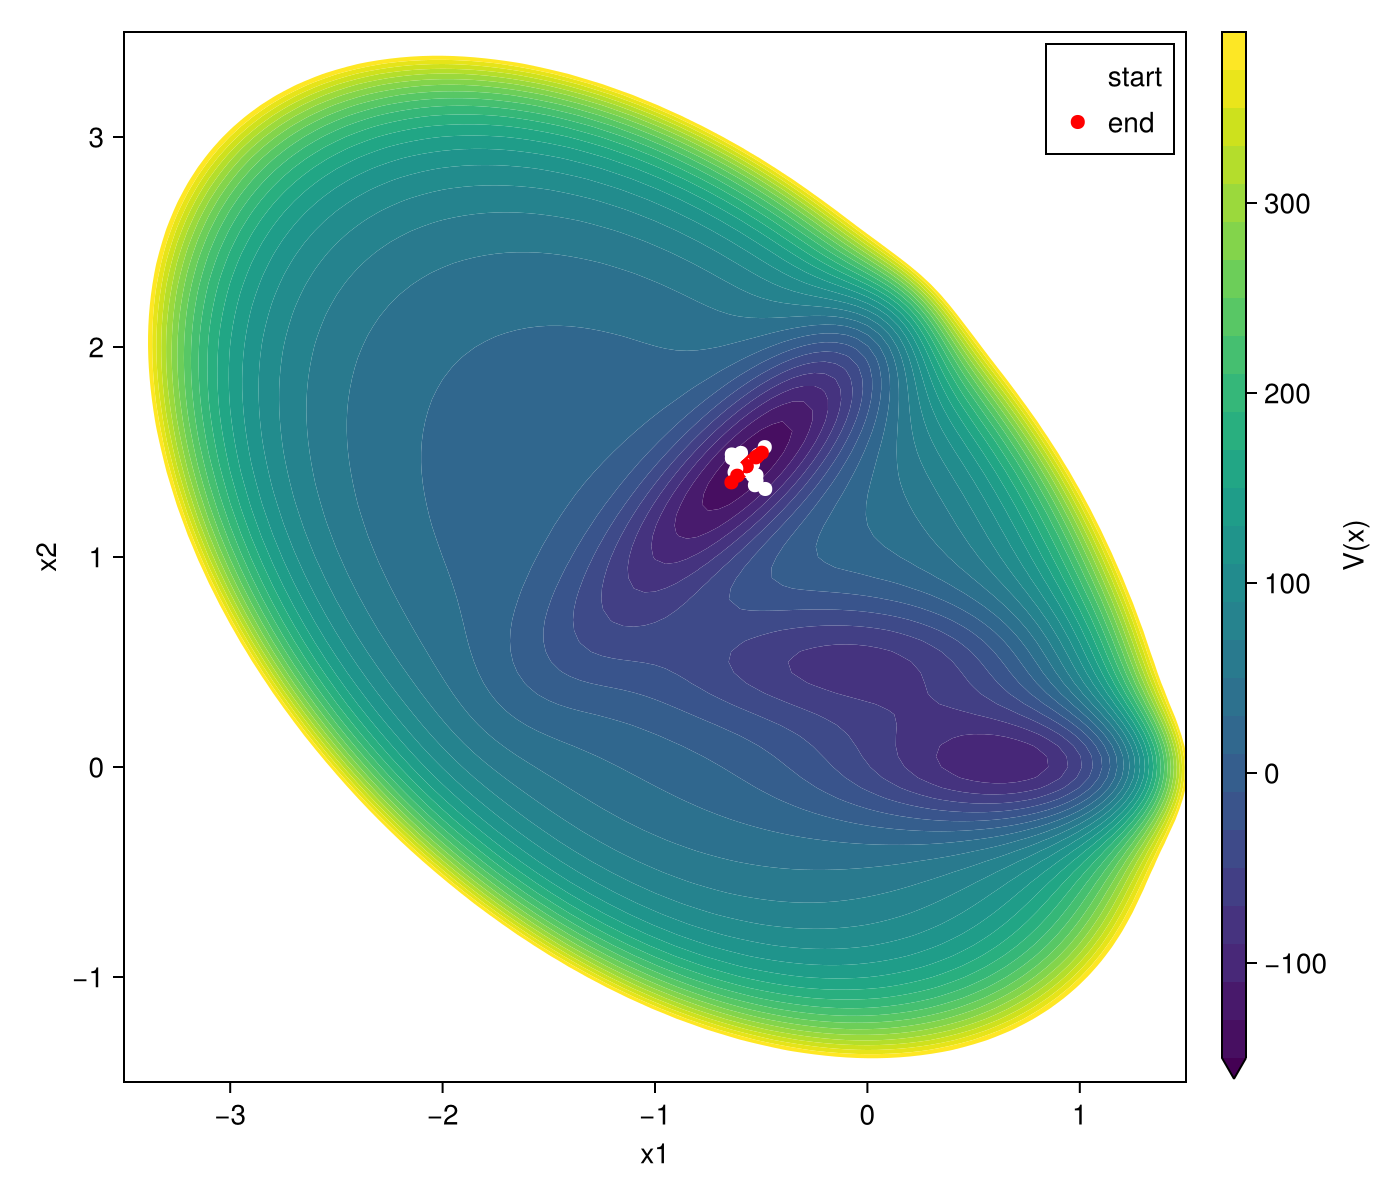

In [57]:
f3 = plot_md_trajectory(ens, ctr_grid, fill=true, lvls=ctr_lvls, showpath=false)

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/joannazou/.julia/packages/Makie/ND0gA/src/scenes.jl:220


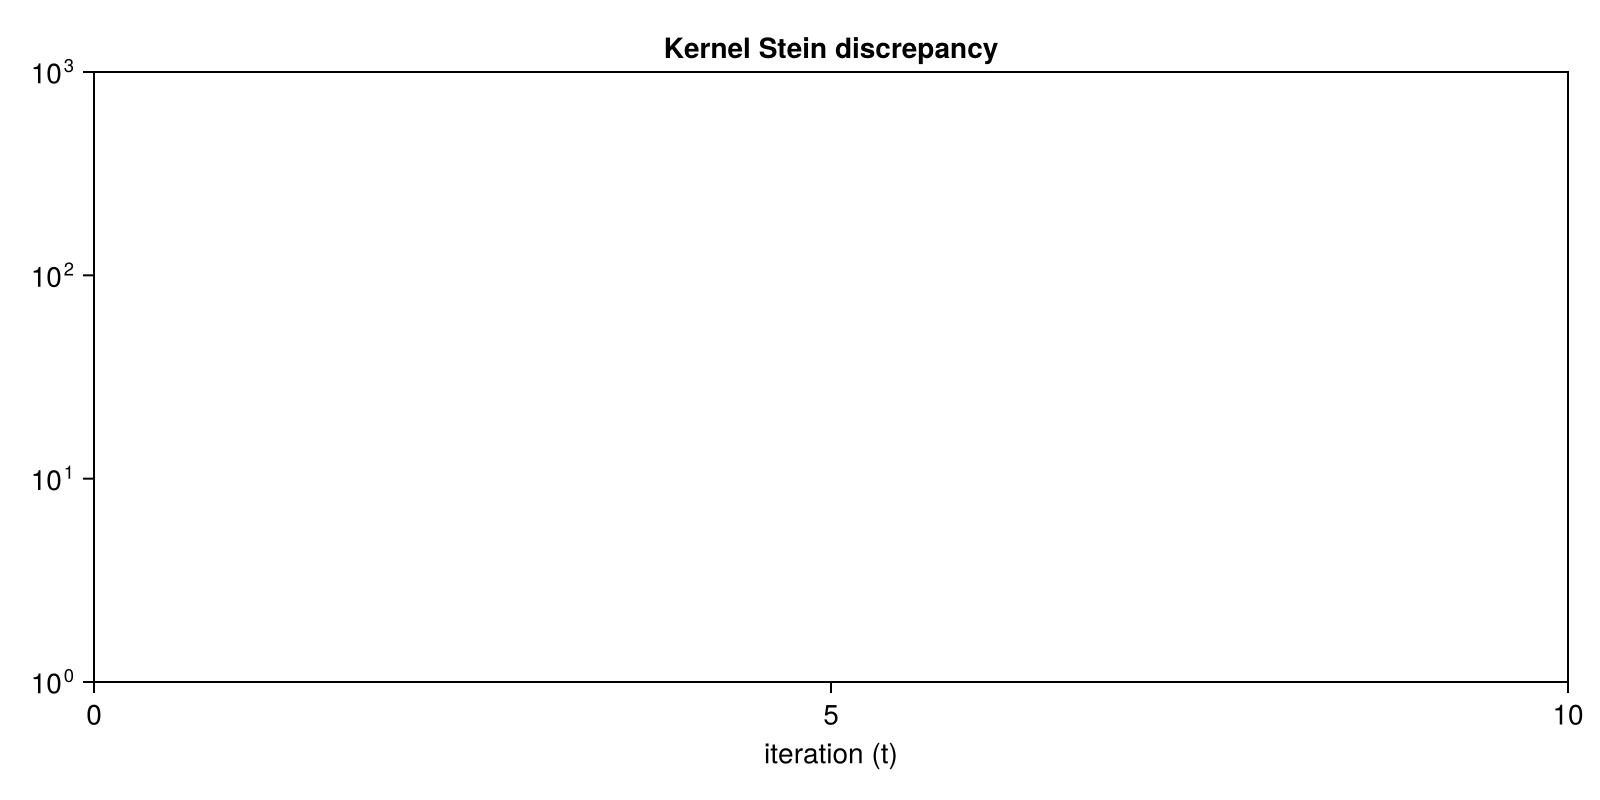

In [59]:
f3b = plot_step_mean(ens, "Kernel Stein discrepancy", logscl=true)


In [60]:
# define simulator
sim_svgd = StochasticSVGD(
            dt=0.002u"ps",
            kernel=rbf,
            kernel_bandwidth=median_kernel_bandwidth,
            sys_fix=sys_fix,
            temperature=temp,
            friction=1.0u"ps^-1")

StochasticSVGD{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, RBF, System{2, false, Float64, Vector{Atom{Float64, Quantity{Float64, 𝐌 𝐍⁻¹, Unitful.FreeUnits{(g, mol⁻¹), 𝐌 𝐍⁻¹, nothing}}, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}}, Vector{SVector{2, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}}, RectangularBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Vector{SVector{2, Quantity{Float64, 𝐋 𝐓⁻¹, Unitful.FreeUnits{(nm, ps⁻¹), 𝐋 𝐓⁻¹, nothing}}}}, Vector{Any}, Nothing, Tuple{}, Tuple{}, Tuple{MullerBrown{SVector{4, Quantity{Float64, 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², Unitful.FreeUnits{(kJ, mol⁻¹), 𝐋² 𝐌 𝐍⁻¹ 𝐓⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋⁻², Unitful.FreeUnits{(nm⁻²,), 𝐋⁻², nothing}}}, SVector{4, Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}, Unitful.FreeUnits{(kJ, nm⁻¹, mol⁻¹), 𝐋 𝐌 𝐍⁻¹ 𝐓⁻², nothing}, Unitful.FreeUnits{(kJ, mol⁻¹

In [61]:
# run simulation - this will take a few seconds
ens = deepcopy(ens0)
simulate!(ens, sim_svgd, 10_000)

10000-element Vector{Float64}:
 0.06259533516327118
 0.06656069372595858
 0.07698119457658009
 0.0809080718235397
 0.08816195084553115
 0.09293718959052982
 0.09550107402542327
 0.09306362751484135
 0.1105866133144605
 0.09834614436760618
 ⋮
 0.12035467579854443
 0.12413505662849254
 0.1347690446404259
 0.13730036471264076
 0.12771233708389648
 0.12404758505748298
 0.13254870448708167
 0.14663483229205515
 0.13257540466071954

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/joannazou/.julia/packages/Makie/ND0gA/src/scenes.jl:220


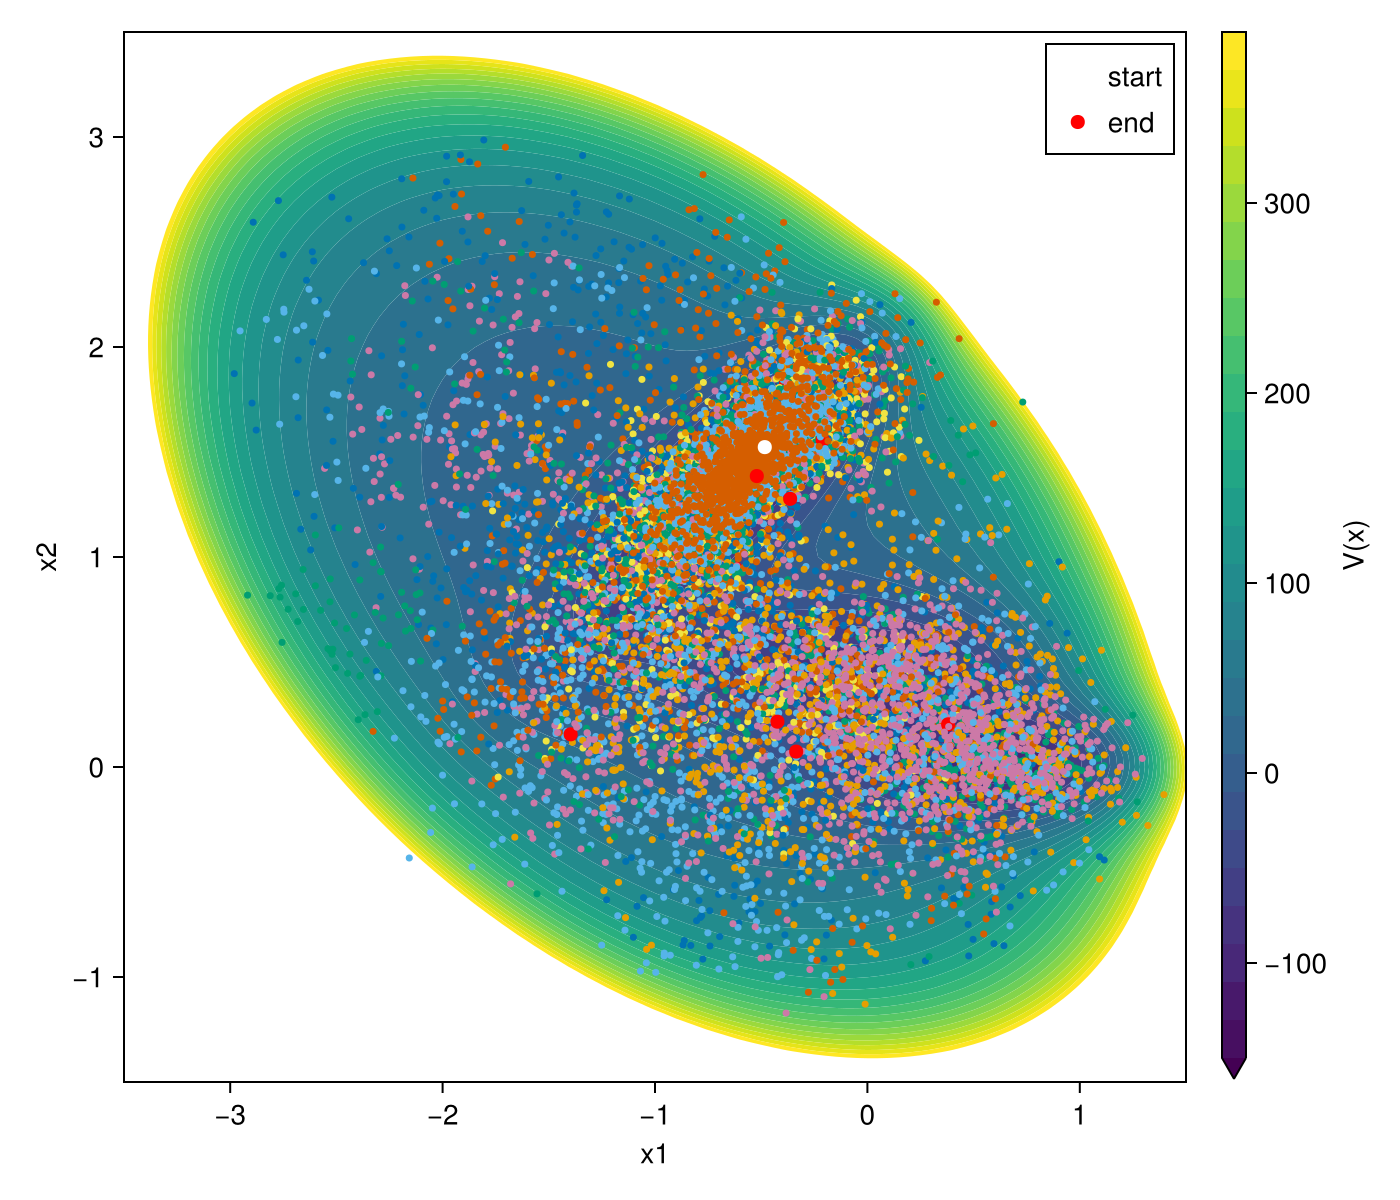

In [62]:
f4 = plot_md_trajectory(ens, ctr_grid, fill=true, lvls=ctr_lvls, showpath=false)